#Cloud iAtlas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing required modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import os
import pandas as pd
from time import time
import re
from collections import namedtuple
import cv2
from google.colab.patches import cv2_imshow
import collections

## DATA PREPARATION

### IMAGE PREPARATION

#### Image resizing & grayscale

In [ ]:


# make tgt_size optionnal with default value as expected model size ?
# maintain .jpg filter only ?
# Enhancing exception handling



def dir_imgs_resize_and_grayscale(src_dir, tgt_dir, tgt_size):
    for filename in os.listdir(src_dir):
      while True:
        try:
          if filename.endswith(".jpg"):
            img_resize_and_grayscale(os.path.join(inputDirectory, filename), tgt_dir, tgt_size)
          break;
        except ValueError:
          print("Something goes wrong with ", os.path.join(inputDirectory, filename))


def img_resize_and_grayscale(img_path, tgt_dir, tgt_size):
  file_name = os.path.basename(img_path)
  while True:
    try:
      image = Image.open(img_path).convert('L')
      image = image.resize(tgt_size)
      image.save(os.path.join(tgt_dir, file_name))
      break;
    except ValueError:
      print("Something goes wrong with ", os.path.join(inputDirectory, file_name))

inputDirectory = '/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images'
outputdirectory = '/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images_refact/'
new_size = (525, 350)


start = time()

dir_imgs_resize_and_grayscale(inputDirectory, outputdirectory, new_size)

end = time()
print("Délai de traitement :", end - start)
# 785 secondes

Délai de traitement : 785.7588679790497


#### Black bar handling

In [ ]:
# Zone de création du dataset d'identification des barres noires sur les images


start = time()

df_bar_by_image = pd.DataFrame(columns=['image','bar_pixel', 'bar_percent'])

inputDirectory = '/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images_refact'

lower_black = np.array([0, 0, 0], dtype = "uint8")
upper_black= np.array([1, 1, 1], dtype = "uint8")

for filename in os.listdir(inputDirectory):
  if filename.endswith(".jpg"):
    image = cv2.imread(os.path.join(inputDirectory, filename))
    mask = cv2.inRange(image, lower_black, upper_black)

    unique, counts = np.unique(mask, return_counts=True)

    for bit, count in zip(unique, counts):
      if bit == 255:
        bar_pixel = count
        bar_percent = count / np.sum(counts) * 100
        df_bar_by_image.loc[len(df_bar_by_image)] = [filename, bar_pixel, bar_percent]

# df_bar_by_image.to_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_bar_by_refact_image_20230911.csv', sep = ';')

print("Délai de traitement :", (time() - start) / 60, " minutes")


# detected_output = cv2.bitwise_and(image, image, mask = mask)
# cv2_imshow(mask)

#       bar_pixel	    bar_percent
# count	5555.000000	  5555.000000
# mean	18809.615842	10.236526
# std	  7507.364832	  4.085641
# min	  2.000000	    0.001088
# 25%	  17477.000000	9.511293
# 50%	  19068.000000	10.377143
# 75%	  25042.500000	13.628571
# max	  156405.000000	85.11836



Délai de traitement : 1.0427712162335714  minutes


In [ ]:
df_bar_by_image.describe()

,Unnamed: 0,bar_pixel,bar_percent
count,5555.000000,5555.000000,5555.000000
mean,2777.000000,18809.615842,10.236526
std,1603.734704,7507.364832,4.085641
min,0.000000,2.000000,0.001088
25%,1388.500000,17477.000000,9.511293
50%,2777.000000,19068.000000,10.377143
75%,4165.500000,25042.500000,13.628571
max,5554.000000,156405.000000,85.118367


In [ ]:
df_bar_by_image.loc[(df_bar_by_image['bar_percent'] > 20)]


,Unnamed: 0,image,bar_pixel,bar_percent
185,185,3b9a092.jpg,133288,72.537687
191,191,3c1e099.jpg,37672,20.501769
295,295,400a38d.jpg,100624,54.761361
365,365,42ac1b7.jpg,50946,27.725714
608,608,076de5e.jpg,37268,20.281905
944,944,171e62f.jpg,41027,22.327619
984,984,17fe76e.jpg,81397,44.297687
1702,1702,24884e7.jpg,156405,85.118367
2705,2705,5265e81.jpg,109169,59.411701
3763,3763,838cd7a.jpg,65946,35.888980


#### Synthesis

Proposition d'exclure les 8 images dont la part de barre noire est supérieure à 30%
Toutefois, c'est au doigt mouillé car le mieux finalement est de trouver la correspondance entre rectangle des labels et zone noires

### DATA PREPARATION

#### Data cleaning

In [ ]:
# check if exist and DataFrame load of train.csv
if 'df' in locals():
  del df

df = pd.read_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train.csv')
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [ ]:
df[['image', 'label']] = df['Image_Label'].str.split('_', expand=True)
df = df.drop(columns=['Image_Label'])
df['has_label'] = np.where(df['EncodedPixels'].isna(),np.nan,df['label'])


In [ ]:
df = df.join(pd.get_dummies(data = df['has_label'], prefix='label'))
df['label_count'] = df['label_Fish'] + df['label_Flower'] + df['label_Gravel'] + df['label_Sugar']
df=df.dropna(axis=0, how='any')

In [ ]:
df.head(20)

,EncodedPixels,image,label,has_label,label_Fish,label_Flower,label_Gravel,label_Sugar,label_count
0,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,Fish,1,0,0,0,1
1,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,Flower,0,1,0,0,1
4,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,Fish,1,0,0,0,1
5,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,Flower,0,1,0,0,1
7,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,Sugar,0,0,0,1,1
8,3510 690 4910 690 6310 690 7710 690 9110 690 1...,0031ae9.jpg,Fish,Fish,1,0,0,0,1
9,2047 703 3447 703 4847 703 6247 703 7647 703 9...,0031ae9.jpg,Flower,Flower,0,1,0,0,1
11,658170 388 659570 388 660970 388 662370 388 66...,0031ae9.jpg,Sugar,Sugar,0,0,0,1,1
13,100812 462 102212 462 103612 462 105012 462 10...,0035239.jpg,Flower,Flower,0,1,0,0,1
14,65400 380 66800 380 68200 380 69600 380 71000 ...,0035239.jpg,Gravel,Gravel,0,0,1,0,1


#### Graph Analysis

<Figure size 1600x800 with 0 Axes>

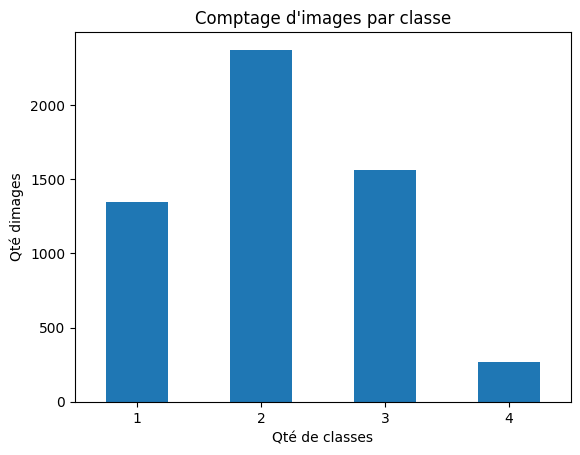

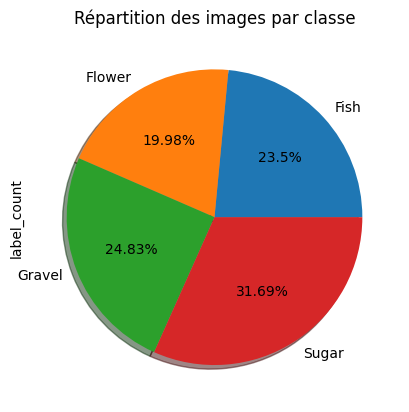

In [ ]:
%matplotlib inline

plt.figure(figsize = (16, 8))
# plt.subplot(121)
pd.DataFrame(df[['image','label_count']].groupby('image').sum()).reset_index().groupby('label_count').count().plot(kind="bar", legend = None)
plt.xlabel('Qté de classes')
plt.ylabel('Qté d''images')
plt.xticks(rotation = 0)
plt.title("Comptage d'images par classe")
plt.show();
# plt.subplot(122)
(df.groupby(['label'])['label_count'].sum()).plot(kind="pie", autopct = (lambda x : str(round(x, 2)) + '%'), shadow = True)
plt.title("Répartition des images par classe")
plt.show();

#### Data prep for rectangle

In [ ]:
def groupWords(val):
    if type(val) != str:
        return

    newList = []
    words = val.split()

    for i in range(0, len(words), 2):
        startingPix = words[i]
        length = words[i+1]
        newList.append(f'''{startingPix} {length}''')
    return newList

df['EncodedPixels'] = df['EncodedPixels'].apply(groupWords)
df = df.explode("EncodedPixels").reset_index()


In [ ]:
df[['startPixel', 'nbPixels']] = df['EncodedPixels'].str.split(' ', expand=True)
df = df.astype({'startPixel': 'int32', 'nbPixels': 'int32'})

In [ ]:
df['x1'] = np.ceil(df['startPixel'] / 1400)
df['x2'] = df['x1'] + 1
df['y1'] = df['startPixel'] - ((df['x1'] - 1) * 1400)
df['y2'] = df['y1'] + df['nbPixels']
df_rectangle = df.drop(columns=['index','startPixel','nbPixels','EncodedPixels','has_label','label_Fish','label_Flower','label_Gravel','label_Sugar','label_count'])

In [ ]:
df_rectangle.head()

,image,label,x1,x2,y1,y2
0,0011165.jpg,Fish,190.0,191.0,318.0,1255.0
1,0011165.jpg,Fish,191.0,192.0,318.0,1255.0
2,0011165.jpg,Fish,192.0,193.0,318.0,1255.0
3,0011165.jpg,Fish,193.0,194.0,318.0,1255.0
4,0011165.jpg,Fish,194.0,195.0,318.0,1255.0


In [ ]:
# EN CAS D'ERREUR sur le format Numeric des colonnes startPixel, nbPixels
# df[['startPixel', 'nbPixels']] = df[['startPixel', 'nbPixels']].apply(pd.to_numeric, errors='coerce')


# EN CAS D'ERREUR, PERMET D'IDENTIFIER LES VALEURS NUMERIQUES
# import re

# pattern = re.compile(r'\D')
# non_numeric_rows = df.apply(lambda x: x.str.contains(pattern).any(), axis=1)

In [ ]:
def overlap(rec1, rec2):
  # Vérifier si les rectangles sont séparés horizontalement
  if rec1.x2 < rec2.x1 or rec2.x2 < rec1.x1:
    return False
  # Vérifier si les rectangles sont séparés verticalement
  if rec1.y2 < rec2.y1 or rec2.y2 < rec1.y1:
    return False
  # Sinon, les rectangles se chevauchent ou sont contigus
  return True

# ZONE TEST DE LA FONCTION
RECT_NAMEDTUPLE = namedtuple('RECT_NAMEDTUPLE', 'x1 y1 x2 y2')

Rect1 = RECT_NAMEDTUPLE(x1=376, y1=1032, x2=381, y2=1080)
Rect2 = RECT_NAMEDTUPLE(x1=376, y1=1057, x2=378, y2=1084)

print(overlap(Rect1, Rect2)) # True

True


In [ ]:
cpt = 0
start = time()
rec_cpt = 0
i = 1
df_tmp = df_rectangle

while i > 0:
    i = 0
    rec_cpt += 1
    print ("...:: Boucle :", rec_cpt, " ::...")
    RECT_NAMEDTUPLE = namedtuple('RECT_NAMEDTUPLE', 'x1 y1 x2 y2')

    df_synth = pd.DataFrame(columns=['image','label','x1', 'y1', 'x2', 'y2'])

    df_gb_image = df_tmp.sort_values(['image','label','x1']).groupby(["image", "label"])
    for (image, label), group in df_gb_image:
        rect_list = []
        for row in group.itertuples():
            row_rect = RECT_NAMEDTUPLE(row.x1 - 1, row.y1 - 1, row.x2, row.y2 + 1)
            for rect_idx, rect in enumerate(rect_list):
                if overlap(rect, row_rect):
                    i += 1
                    rect_list[rect_idx] = rect._replace(
                        x1=min(rect.x1, row_rect.x1),
                        y1=min(rect.y1, row_rect.y1),
                        x2=max(rect.x2, row_rect.x2),
                        y2=max(rect.y2, row_rect.y2)
                    )
                    break
            else:
                rect_list.append(row_rect)

        for rect in rect_list:
            df_synth.loc[len(df_synth)] = [image, label, rect.x1 + 1, rect.y1 + 1, rect.x2, rect.y2 - 1]
        cpt += 1
        if cpt%1000 == 0:
            print(cpt, " image/label traitées")
            print("Délai de traitement :", (time() - start) / 60, " minutes")
    df_tmp = df_synth
    print(i, " chevauchements constatés dans cette boucle")

df_synth = df_synth.astype({'x1': 'int32', 'y1': 'int32', 'x2': 'int32', 'y2': 'int32'})
df_synth.to_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_data_unique_rectangle.csv', sep = ';', index = False)
print("Délai total de traitement :", (time() - start) / 60, " minutes")

...:: Boucle : 1  ::...
1000  image/label traitées
Délai de traitement : 1.0037865002950033  minutes
2000  image/label traitées
Délai de traitement : 1.888269305229187  minutes
3000  image/label traitées
Délai de traitement : 3.0118647535641987  minutes
4000  image/label traitées
Délai de traitement : 4.126179492473602  minutes
5000  image/label traitées
Délai de traitement : 5.5392796158790585  minutes
6000  image/label traitées
Délai de traitement : 7.043094487984975  minutes
7000  image/label traitées
Délai de traitement : 8.744063019752502  minutes
8000  image/label traitées
Délai de traitement : 10.483785637219746  minutes
9000  image/label traitées
Délai de traitement : 12.486167605717977  minutes
10000  image/label traitées
Délai de traitement : 14.186101019382477  minutes
11000  image/label traitées
Délai de traitement : 16.142448977629343  minutes
18625667  chevauchements constatés dans cette boucle
...:: Boucle : 2  ::...
12000  image/label traitées
Délai de traitement : 18.2

In [ ]:
if 'df_synth' in locals():
  del df_synth

df_synth = pd.read_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_data_unique_rectangle.csv', sep = ';')
df_synth.head()

,image,label,x1,y1,x2,y2
0,0011165.jpg,Fish,190.0,318.0,1185.0,1255.0
1,0011165.jpg,Flower,969.0,314.0,2096.0,1367.0
2,002be4f.jpg,Fish,168.0,10.0,2088.0,891.0
3,002be4f.jpg,Flower,957.0,879.0,2099.0,1398.0
4,002be4f.jpg,Sugar,49.0,295.0,946.0,645.0


In [ ]:
df_synth

,image,label,x1,y1,x2,y2
0,0011165.jpg,Fish,190.0,318.0,1185.0,1255.0
1,0011165.jpg,Flower,969.0,314.0,2096.0,1367.0
2,002be4f.jpg,Fish,168.0,10.0,2088.0,891.0
3,002be4f.jpg,Flower,957.0,879.0,2099.0,1398.0
4,002be4f.jpg,Sugar,49.0,295.0,946.0,645.0
...,...,...,...,...,...,...
17163,ffd3dfb.jpg,Sugar,10.0,145.0,1852.0,980.0
17164,ffd6680.jpg,Flower,1079.0,267.0,2100.0,1399.0
17165,ffd6680.jpg,Gravel,29.0,528.0,796.0,1351.0
17166,ffea4f4.jpg,Flower,854.0,660.0,1745.0,1335.0


In [ ]:
inputDirectory = '/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images'
outputDirectory = '/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images_rectangle/'

start = time()
i = 0
df_synth_gb_image = df_synth.groupby(["image"])

for image_name, group in df_synth_gb_image:
  # print(os.path.join(inputDirectory, image_name))
  with Image.open(os.path.join(inputDirectory, image_name)) as image:
    image = image.convert('RGBA')
    new = Image.new('RGBA', image.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(new)

    for row in group.itertuples():
      draw.rectangle(((row.x1, row.y1), (row.x2, row.y2)), outline='red', width=1)
      draw.text((row.x1, row.y1), row.label, fill = 'red', size = 20)
      # font=ImageFont.truetype(font ="arial"), size = 20)
      image = Image.alpha_composite(image, new)
    image.save(os.path.join(outputDirectory, image_name.replace("jpg","png")))
    i += 1
    if i%100 == 0:
      print("...:: ", i, " images traitées ::...")
      print("Délai de traitement :", (time() - start) / 60, " minutes")

print("Délai de traitement total:", (time() - start) / 60, " minutes")

<ipython-input-11-a93a7c66e114>:8: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for image_name, group in df_synth_gb_image:


...::  100  images traitées ::...
Délai de traitement : 2.4152103900909423  minutes
...::  200  images traitées ::...
Délai de traitement : 5.224219210942587  minutes
...::  300  images traitées ::...
Délai de traitement : 8.07355660200119  minutes
...::  400  images traitées ::...
Délai de traitement : 10.810782305399577  minutes
...::  500  images traitées ::...
Délai de traitement : 13.607187803586324  minutes
...::  600  images traitées ::...
Délai de traitement : 16.355461891492208  minutes
...::  700  images traitées ::...
Délai de traitement : 19.178472447395325  minutes
...::  800  images traitées ::...
Délai de traitement : 21.9590336004893  minutes
...::  900  images traitées ::...
Délai de traitement : 24.678804806868236  minutes
...::  1000  images traitées ::...
Délai de traitement : 27.463467593987783  minutes
...::  1100  images traitées ::...
Délai de traitement : 30.369165456295015  minutes
...::  1200  images traitées ::...
Délai de traitement : 33.17632962067922  min

## Section B

In [ ]:
import pandas as pd
import numpy as np

dataPath = '/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas'
df = pd.read_csv(dataPath+'/sample_submission.csv')


FileNotFoundError: ignored

In [ ]:
import os
# récupérer le chemin du répertoire courant
path = os.getcwd()
print("Le répertoire courant est : " + path)

Le répertoire courant est : /content


## Section C : Calcul et affichage de quelques métriques : moyenne, écart-type, taille, bruit spatial de chaque nuage

In [ ]:
dataPath = '/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas'
df = pd.read_csv(dataPath+'/train.csv')

In [ ]:
df = df.dropna()
df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
5,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...
7,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...


In [ ]:
def get_mask(rle_string, width_origin, height_origin):
    rows, cols = height_origin, width_origin
    if rle_string==-1:
        mask = np.zeros((rows, cols))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        img = np.zeros(rows*cols, dtype=bool)
        for index, length in rle_pairs:
            index-=1
            img[index:index+length] = 1
        img = img.reshape(cols, rows)
        mask = img.T
    return mask

def score_bruit_spatial(im, mask):
    kernel = np.ones((3, 3)) / 9
    im = np.mean(im, axis=2)
    diff = im - cv2.filter2D(im, -1, kernel)
    im_var = np.square(diff)
    res = np.sqrt(np.mean(im_var[mask>0]))
    return res

def cloud_mean(im, mask):
    im = np.mean(im, axis=2)
    res = np.mean(im[mask>0])
    return res

def cloud_std(im, mask):
    im = np.mean(im, axis=2)
    res = np.std(im[mask>0])
    return res

def gradient_moy(im, mask):
    im = np.mean(im, axis=2)
    gradient_x = np.zeros_like(im, dtype=float)
    gradient_y = np.zeros_like(im, dtype=float)
    for y in range(1, im.shape[0]):
      for x in range(1, im.shape[1]):
        gradient_x[y, x] = im[y, x] - im[y, x - 1]
        gradient_y[y, x] = im[y, x] - im[y - 1, x]
    dir = np.arctan2(gradient_y, gradient_x)
    res = np.mean(dir[mask>0])
    return res

In [ ]:
df['spatial_noise'] = df.apply(lambda row: score_bruit_spatial(plt.imread('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images/' + (row['Image_Label']).split("_")[0]), get_mask(row['EncodedPixels'], 2100, 1400)), axis=1)


In [ ]:
df['cloud_mean'] = df.apply(lambda row: cloud_mean(plt.imread('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images/' + (row['Image_Label']).split("_")[0]), get_mask(row['EncodedPixels'], 2100, 1400)), axis=1)
df['cloud_std'] = df.apply(lambda row: cloud_std(plt.imread('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images/' + (row['Image_Label']).split("_")[0]), get_mask(row['EncodedPixels'], 2100, 1400)), axis=1)


In [ ]:
df['file_name'] = df['Image_Label'].apply(lambda x: x.split("_")[0])
df['cloud_class'] = df['Image_Label'].apply(lambda x: x.split("_")[1])
df['masque_size'] = df['EncodedPixels'].apply(lambda x : get_mask(x, 2100, 1400).sum()/(2100*1400))

In [ ]:
df['gradient_dir_moy'] = df.apply(lambda row: gradient_moy(plt.imread('/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas/train_images/' + (row['Image_Label']).split("_")[0]), get_mask(row['EncodedPixels'], 2100, 1400)), axis=1)


FileNotFoundError: ignored

In [ ]:
df.head()

,Image_Label,EncodedPixels,file_name,cloud_class,masque_size,spatial_noise,cloud_mean,cloud_std
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,0.317113,15.411074,61.809107,54.880404
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,0.393234,10.497660,105.112083,55.491192
2,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,0.572900,10.838509,85.523558,65.079097
3,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,0.201598,14.359307,82.658512,64.433338
4,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,0.106786,8.767750,56.973950,25.487097


In [ ]:
"""
df.to_csv('/content/drive/My Drive/Partage Full CloudiAtlas/Cloud_iAtlas/train_mean_std_spatial_noise.csv', sep = ';', index = False)
"""

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

dataPath = '/content/drive/MyDrive/Partage Full CloudiAtlas/Cloud_iAtlas'
df = pd.read_csv(dataPath+'/train_mean_std_spatial_noise.csv', sep =';')

sns.set_theme()

In [ ]:
df.head()

,Image_Label,EncodedPixels,file_name,cloud_class,masque_size,spatial_noise,cloud_mean,cloud_std
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,0.317113,15.411074,61.809107,54.880404
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,0.393234,10.497660,105.112083,55.491192
2,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,0.572900,10.838509,85.523558,65.079097
3,002be4f.jpg_Flower,1339279 519 1340679 519 1342079 519 1343479 51...,002be4f.jpg,Flower,0.201598,14.359307,82.658512,64.433338
4,002be4f.jpg_Sugar,67495 350 68895 350 70295 350 71695 350 73095 ...,002be4f.jpg,Sugar,0.106786,8.767750,56.973950,25.487097


In [ ]:
sns.boxplot(x='cloud_class', y='gradient_dir_moy', data=df)

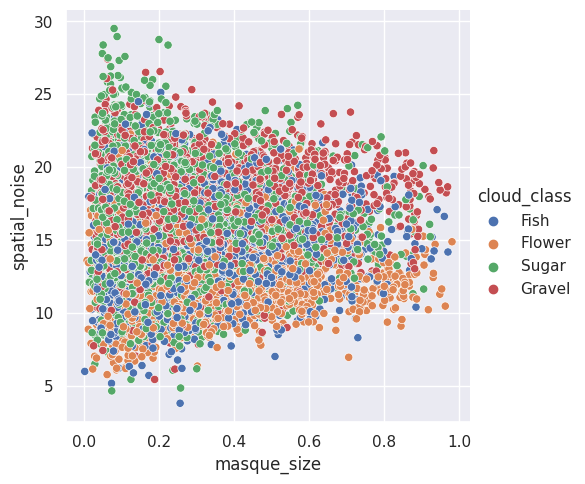

In [ ]:
#sns.relplot(x='cloud_mean', y='cloud_std', hue='cloud_class', data=df);
sns.relplot(x='masque_size', y='spatial_noise', hue='cloud_class', data=df);

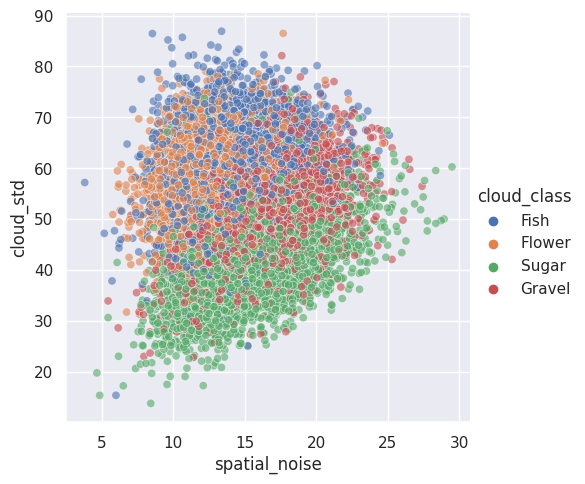

In [ ]:
# sns.relplot(x='cloud_std', y='spatial_noise', hue='cloud_class', data=df);
sns.relplot(x='spatial_noise', y='cloud_std', hue='cloud_class', data=df, alpha = 0.6);


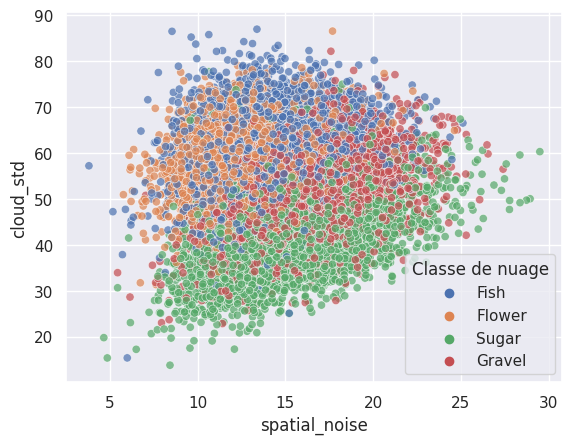

In [ ]:
sns.scatterplot(x='spatial_noise', y='cloud_std', hue='cloud_class', data=df, alpha=0.7)

plt.legend(title='Classe de nuage')

In [ ]:
from scipy.spatial import cKDTree
# Supposons que vous ayez un DataFrame df avec les colonnes 'colonne1', 'colonne2', 'categorie'

# Définissez une distance minimale pour agréger les points proches
distance_minimale = 30  # À adapter en fonction de votre jeu de données

# Créez un arbre KD (KD-Tree) à partir des coordonnées des points
points = df[['spatial_noise', 'cloud_std']].values
kdtree = cKDTree(points)

# Recherchez les groupes de points proches
groupes = list(kdtree.query_ball_tree(kdtree, distance_minimale))

# Créez un nouveau DataFrame pour stocker les points agrégés
df_aggrege = pd.DataFrame(columns=['spatial_noise', 'cloud_std', 'cloud_class'])

# Agrégez les points en calculant leur moyenne et en les assignant à une catégorie fictive
for i, groupe in enumerate(groupes):
    if groupe:
        points_groupe = points[groupe]
        moyenne_x = points_groupe[:, 0].mean()
        moyenne_y = points_groupe[:, 1].mean()
        categorie = df.loc[i, 'cloud_class']  # Obtenez la catégorie d'origine
        #df_aggrege = df_aggrege.append({'spatial_noise': moyenne_x, 'cloud_std': moyenne_y, 'cloud_class': categorie}, ignore_index=True)
        df_aggrege = pd.concat([df_aggrege, pd.DataFrame({'spatial_noise': moyenne_x, 'cloud_std': moyenne_y, 'cloud_class': categorie})], ignore_index=True)

# Utilisez seaborn.scatterplot() pour afficher le nuage de points agrégés
sns.scatterplot(x='spatial_noise', y='cloud_std', hue='cloud_class', data=df_aggrege, s=100, alpha=0.7)  # Ajustez la taille des points (s) selon vos préférences

# Ajoutez une légende
plt.legend(title='Classe de nuage')

In [ ]:
df_aggrege.head()

,spatial_noise,cloud_std,cloud_class
0,15.249810,54.957194,Groupe
1,12.011548,55.680394,Groupe
2,12.407139,64.425672,Groupe
3,14.068560,64.027382,Groupe
4,10.590327,27.118517,Groupe


<Axes: xlabel='cloud_class', ylabel='spatial_noise'>

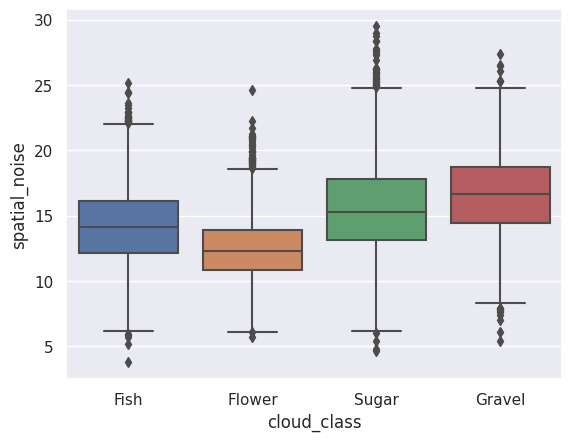

In [ ]:
# sns.boxplot(x='cloud_class', y='cloud_mean', data=df)
# sns.boxplot(x='cloud_class', y='cloud_std', data=df)
# sns.boxplot(x='cloud_class', y='masque_size', data=df)
sns.boxplot(x='cloud_class', y='spatial_noise', data=df)